In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Hyperparameters
batch_size = 64
lr = 0.0002
z_dim = 100  # Size of the random noise vector
epochs = 50

# Transform for MNIST data
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])  # Normalize to [-1, 1]
])

# MNIST dataset
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Generator Model
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(z_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 1024),
            nn.ReLU(),
            nn.Linear(1024, 28 * 28),
            nn.Tanh()
        )
    
    def forward(self, z):
        img = self.model(z)
        img = img.view(img.size(0), 1, 28, 28)
        return img

# Discriminator Model
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(28 * 28, 1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )
    
    def forward(self, img):
        img_flat = img.view(img.size(0), -1)
        validity = self.model(img_flat)
        return validity

# Initialize models
generator = Generator()
discriminator = Discriminator()

# Loss function
criterion = nn.BCELoss()

# Optimizers
optimizer_G = optim.Adam(generator.parameters(), lr=lr)
optimizer_D = optim.Adam(discriminator.parameters(), lr=lr)

# Training loop
for epoch in range(epochs):
    for i, (imgs, _) in enumerate(train_loader):
        
        # Adversarial ground truths
        valid = torch.ones(imgs.size(0), 1)
        fake = torch.zeros(imgs.size(0), 1)
        
        # ---------------------
        #  Train Generator
        # ---------------------
        optimizer_G.zero_grad()
        
        # Sample noise as generator input
        z = torch.randn(imgs.size(0), z_dim)
        
        # Generate a batch of images
        gen_imgs = generator(z)
        
        # Loss measures generator's ability to fool the discriminator
        g_loss = criterion(discriminator(gen_imgs), valid)
        
        g_loss.backward()
        optimizer_G.step()
        
        # ---------------------
        #  Train Discriminator
        # ---------------------
        optimizer_D.zero_grad()
        
        # Measure discriminator's ability to classify real from generated images
        real_loss = criterion(discriminator(imgs), valid)
        fake_loss = criterion(discriminator(gen_imgs.detach()), fake)
        d_loss = (real_loss + fake_loss) / 2
        
        d_loss.backward()
        optimizer_D.step()
        
        # Print training progress
        if i % 200 == 0:
            print(f"[Epoch {epoch}/{epochs}] [Batch {i}/{len(train_loader)}] [D loss: {d_loss.item():.6f}] [G loss: {g_loss.item():.6f}]")


[Epoch 0/50] [Batch 0/938] [D loss: 0.701494] [G loss: 0.700533]
[Epoch 0/50] [Batch 200/938] [D loss: 0.048090] [G loss: 3.056787]
[Epoch 0/50] [Batch 400/938] [D loss: 0.030314] [G loss: 3.941838]
[Epoch 0/50] [Batch 600/938] [D loss: 0.001297] [G loss: 6.393301]
[Epoch 0/50] [Batch 800/938] [D loss: 0.017344] [G loss: 4.454923]
[Epoch 1/50] [Batch 0/938] [D loss: 0.028558] [G loss: 17.824167]
[Epoch 1/50] [Batch 200/938] [D loss: 0.063349] [G loss: 8.478793]
[Epoch 1/50] [Batch 400/938] [D loss: 0.167611] [G loss: 4.512272]
[Epoch 1/50] [Batch 600/938] [D loss: 0.540595] [G loss: 2.102994]
[Epoch 1/50] [Batch 800/938] [D loss: 0.009222] [G loss: 5.338654]
[Epoch 2/50] [Batch 0/938] [D loss: 0.237987] [G loss: 4.547318]
[Epoch 2/50] [Batch 200/938] [D loss: 0.186005] [G loss: 4.533988]
[Epoch 2/50] [Batch 400/938] [D loss: 0.004467] [G loss: 10.863668]
[Epoch 2/50] [Batch 600/938] [D loss: 0.921805] [G loss: 0.366542]
[Epoch 2/50] [Batch 800/938] [D loss: 0.070505] [G loss: 4.071876]

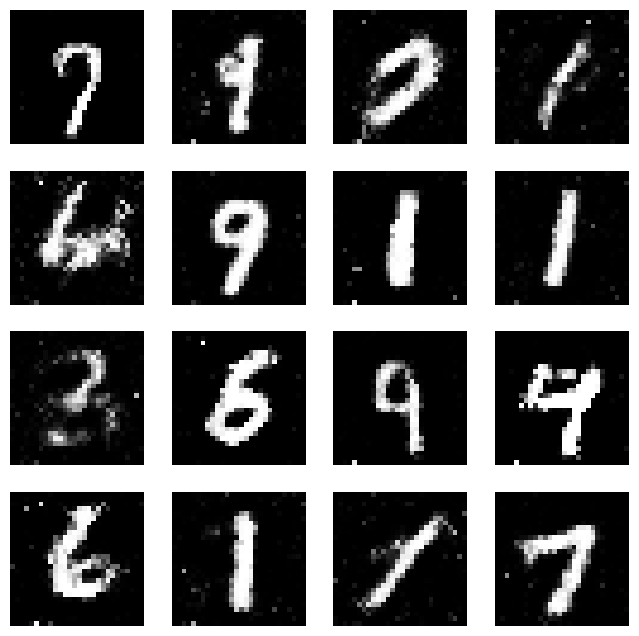

In [2]:
import matplotlib.pyplot as plt

# Function to generate and visualize images from the trained generator
def generate_images(generator, n_images=16):
    # Set the generator to evaluation mode
    generator.eval()
    
    # Generate random noise as input
    z = torch.randn(n_images, z_dim)
    
    # Generate images using the generator
    with torch.no_grad():  # No need to compute gradients
        gen_imgs = generator(z)
    
    # Rescale images from [-1, 1] to [0, 1] for display
    gen_imgs = (gen_imgs + 1) / 2.0
    
    # Plot the generated images
    fig, axes = plt.subplots(4, 4, figsize=(8, 8))
    for i, ax in enumerate(axes.flatten()):
        img = gen_imgs[i].squeeze().cpu().numpy()  # Convert to numpy array and remove channel dimension
        ax.imshow(img, cmap='gray')
        ax.axis('off')  # Turn off the axis
    plt.show()

# After training, call this function to generate images
generate_images(generator)
